<a href="https://colab.research.google.com/github/Sahilshajahan/Hyperspectral/blob/main/Land_cover_classification_of_satellite_imagery_CNN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from scipy.io import loadmat

X = loadmat('/content/Salinas_corrected.mat')['salinas_corrected']
y = loadmat('/content/Salinas_gt.mat')['salinas_gt']


In [2]:
print(f'Data Shape: {X.shape[:-1]}\nNumber of Bands: {X.shape[-1]}')

Data Shape: (512, 217)
Number of Bands: 204


In [3]:
import pandas as pd
df = pd.DataFrame(X.reshape(X.shape[0]*X.shape[1], -1))
df.columns = [f'band{i}' for i in range(1, df.shape[-1]+1)]

df['class'] = y.ravel()

In [4]:

df.head()
     

,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,...,band196,band197,band198,band199,band200,band201,band202,band203,band204,class
0,290,381,585,1041,1316,1397,1319,1462,1643,1683,...,96,109,93,54,79,54,36,11,17,0
1,290,381,519,1041,1316,1352,1319,1462,1643,1683,...,94,111,96,56,83,56,36,11,15,0
2,290,381,585,1041,1286,1352,1300,1412,1614,1644,...,88,107,89,54,81,54,30,11,11,0
3,290,381,585,999,1316,1374,1280,1380,1584,1631,...,86,105,85,56,75,50,30,11,19,0
4,219,381,585,999,1286,1352,1261,1396,1555,1618,...,83,105,83,48,75,50,24,9,17,0


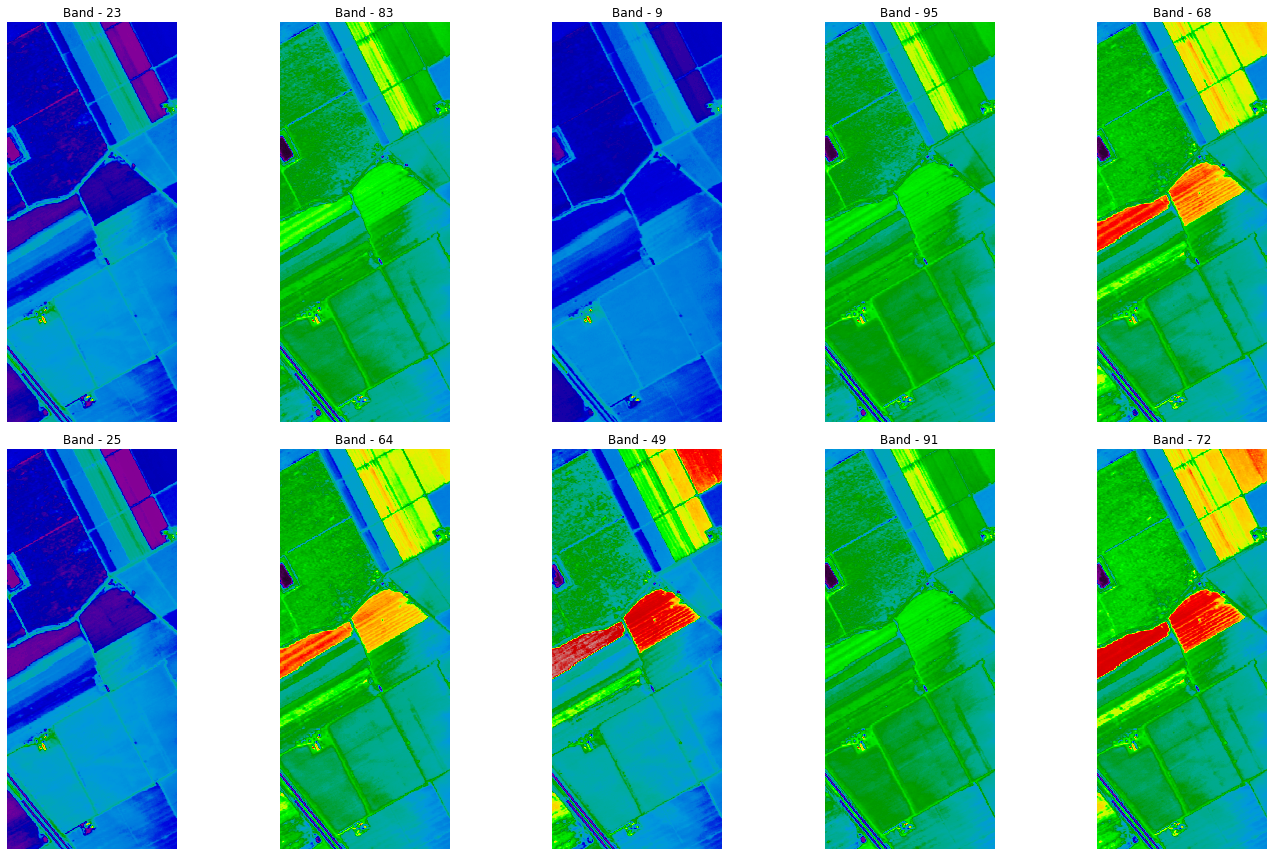

In [5]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize = (20, 12))

ax = fig.subplots(2, 5)

for i in range(2):
  for j in range(5):
    c = np.random.randint(103)
    ax[i][j].imshow(X[:, :, c], cmap='nipy_spectral')
    ax[i][j].axis('off')
    ax[i][j].title.set_text(f"Band - {c}")
    c+=1

plt.tight_layout()
plt.show()


RGB Composite Image

In [6]:
!pip install earthpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 5.1 MB/s 
     |████████████████████████████████| 1.1 MB 39.4 MB/s 
     |████████████████████████████████| 20.9 MB 1.3 MB/s 
     |████████████████████████████████| 7.8 MB 38.0 MB/s 
     |████████████████████████████████| 16.6 MB 38.2 MB/s 


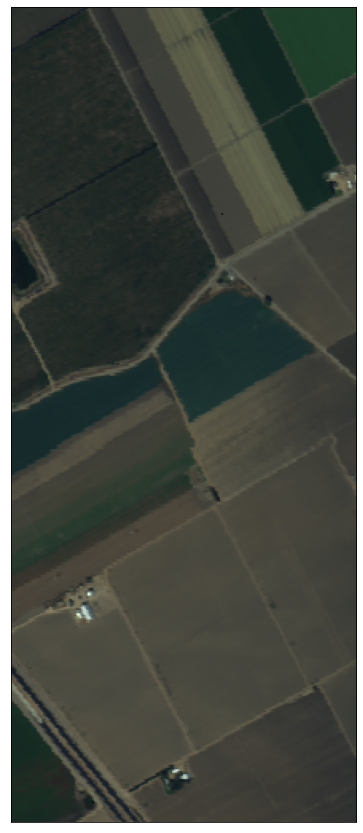

In [7]:

import earthpy.plot as ep

mdata = np.moveaxis(X, -1, 0)

ep.plot_rgb(mdata, (29, 19, 9), figsize=(15, 15)) 

plt.show()

GroundTruth Visualizaation

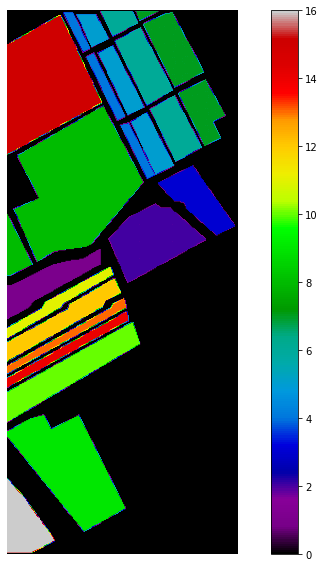

In [8]:
def plot_data(X):
  fig = plt.figure(figsize=(12, 10))
  plt.imshow(X, cmap='nipy_spectral')
  plt.colorbar()
  plt.axis('off')
  plt.show()

plot_data(y)
     

Scaling Data

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import minmax_scale


t_df = df[df['class']!=0]

ind = ['band'+str(i) for i in range(1, t_df.shape[-1])]

X = t_df.loc[:, ind]

y = to_categorical(t_df.loc[:, 'class'])

X_scaled = minmax_scale(X, axis = 0);

X_scaled.shape, y.shape

((54129, 204), (54129, 17))

Split Data

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,
                                                    stratify=y, 
                                                    test_size=0.30)
print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_test: {X_test.shape}\ny_test: {y_test.shape}") 

X_train: (37890, 204)
y_train: (37890, 17)
X_test: (16239, 204)
y_test: (16239, 17)


Build CNN

In [12]:
ip_shape = X_train[1].shape
n_outputs = y_train.shape[1]
X_train[1].ravel().shape

(204,)

In [13]:
X_train = X_train.reshape(-1, 204, 1)
X_test = X_test.reshape(-1, 204, 1)

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Dropout, Flatten

model = Sequential(name = 'Salinas_CNN')
model.add(Conv1D(filters = 64, kernel_size = 3, activation ='relu', input_shape =(ip_shape[0],1), name = 'Layer1'))
model.add(Conv1D(filters = 64, kernel_size = 3, activation ='relu' , name = 'Layer2'))
model.add(Conv1D(filters = 64, kernel_size = 3, activation ='relu' , name = 'Layer3'))

model.add(MaxPooling1D(pool_size = 2, name = 'MaxPooling_Layer1'))
model.add(Dropout(0.4, name = 'Dropout1'))

model.add(Conv1D(filters = 32, kernel_size = 3, activation ='relu', name = 'Layer4'))
model.add(Conv1D(filters = 32, kernel_size = 3, activation ='relu', name = 'Layer5'))
model.add(Conv1D(filters = 32, kernel_size = 3, activation ='relu', name = 'Layer6'))

model.add(MaxPooling1D(pool_size = 2, name = 'MaxPooling_Layer2'))
model.add(Dropout(0.4, name = 'Dropout2'))

model.add(Flatten(name = 'Flatten'))

model.add(Dense(25, activation='relu', name = 'DenseLayer'))

model.add(Dense(n_outputs, activation='softmax', name = 'OutputLayer'))


model.summary()

Model: "Salinas_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer1 (Conv1D)             (None, 202, 64)           256       
                                                                 
 Layer2 (Conv1D)             (None, 200, 64)           12352     
                                                                 
 Layer3 (Conv1D)             (None, 198, 64)           12352     
                                                                 
 MaxPooling_Layer1 (MaxPooli  (None, 99, 64)           0         
 ng1D)                                                           
                                                                 
 Dropout1 (Dropout)          (None, 99, 64)            0         
                                                                 
 Layer4 (Conv1D)             (None, 97, 32)            6176      
                                                       

In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
     

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from time import time

early_stop = EarlyStopping(monitor = 'val_loss',
                            mode = 'min',
                            min_delta = 0,
                            patience = 10,
                            restore_best_weights = True)

checkpoint = ModelCheckpoint(filepath = 'Salinas_Model.h5', 
                             monitor = 'val_loss', 
                             mode ='min', 
                             save_best_only = True)

tensorboard = TensorBoard(log_dir='SA_logs/{}'.format(time()))

In [23]:
hist = model.fit(X_train, 
                       y_train, 
                       epochs = 100, 
                       batch_size = 256 , 
                       validation_data = (X_test, y_test), 
                       callbacks=[early_stop,
                                  checkpoint,
                                  tensorboard])

Epoch 1/100
149/149 [==============================] - 74s 480ms/step - loss: 1.4377 - accuracy: 0.5080 - val_loss: 0.8274 - val_accuracy: 0.6507
Epoch 2/100
149/149 [==============================] - 72s 484ms/step - loss: 0.5649 - accuracy: 0.7701 - val_loss: 0.4244 - val_accuracy: 0.8366
Epoch 3/100
149/149 [==============================] - 69s 460ms/step - loss: 0.4530 - accuracy: 0.8133 - val_loss: 0.3696 - val_accuracy: 0.8619
Epoch 4/100
149/149 [==============================] - 70s 469ms/step - loss: 0.3984 - accuracy: 0.8378 - val_loss: 0.3452 - val_accuracy: 0.8610
Epoch 5/100
149/149 [==============================] - 65s 439ms/step - loss: 0.3755 - accuracy: 0.8458 - val_loss: 0.3938 - val_accuracy: 0.8338
Epoch 6/100
149/149 [==============================] - 69s 464ms/step - loss: 0.3757 - accuracy: 0.8439 - val_loss: 0.3721 - val_accuracy: 0.8497
Epoch 7/100
149/149 [==============================] - 64s 430ms/step - loss: 0.3551 - accuracy: 0.8541 - val_loss: 0.4235 -

In [28]:
hist


,loss,accuracy,val_loss,val_accuracy
0,1.437677,0.508050,0.827359,0.650717
1,0.564925,0.770124,0.424419,0.836628
2,0.453046,0.813302,0.369564,0.861937
3,0.398356,0.837794,0.345197,0.860952
4,0.375544,0.845843,0.393832,0.833795
5,0.375734,0.843864,0.372144,0.849683
6,0.355130,0.854130,0.423472,0.795492
7,0.351414,0.852177,0.298263,0.880227
8,0.330901,0.863790,0.315007,0.861260
9,0.326514,0.863341,0.332424,0.856888


In [ ]:
%load_ext tensorboard

%tensorboard --logdir SA_logs/
     

In [37]:
import plotly.graph_objects as go
hist = pd.DataFrame()

fig = go.Figure()

# fig.add_trace(go.Scatter(x = hist.index, y = hist.loss.values,
#                     mode='lines+markers',
#                     name='Train Loss'))

# fig.add_trace(go.Scatter(x = hist.index, y = hist.accuracy.values,
#                     mode='lines+markers',
#                     name='Train Accuracy'))

# fig.add_trace(go.Scatter(x = hist.index, y = hist.val_loss.values,
#                     mode='lines+markers', name='Test loss'))

# fig.add_trace(go.Scatter(x = hist.index, y = hist.val_accuracy.values,
#                     mode='lines+markers', name='Test Accuracy'))

fig.show()
     

In [38]:
loss, acc = model.evaluate(X_test, y_test)

508/508 [==============================] - 9s 18ms/step - loss: 0.2101 - accuracy: 0.9105


In [39]:
print(f"Accuracy: {acc*100}\nLoss: {loss}")

Accuracy: 91.04624390602112
Loss: 0.21007640659809113


In [40]:
from tensorflow.keras.models import load_model

model = load_model("Salinas_Model.h5")

In [45]:
from sklearn.metrics import (accuracy_score,
                             confusion_matrix, classification_report)
import seaborn as sns


pred = np.argmax(model.predict(X_test), axis=1)

# Classification Report
print(classification_report(pred, np.argmax(y_test, 1),
      target_names = ['1.Brocoli_green_weeds_1', '2.Brocoli_green_weeds_2',
                      '3.Fallow',
                      '4.Fallow_rough_plow',
                      '5.Fallow_smooth',
                      '6.Stubble',
                      '7.Celery',
                      '8.Grapes_untrained',
                      '9.Soil_vinyard_develop',
                      '10.Corn_senesced_green_weeds',
                      '11.Lettuce_romaine_4wk',
                      '12.Lettuce_romaine_5wk',
                      '13.Lettuce_romaine_6wk',
                      '14.Lettuce_romaine_7wk',
                      '15.Vinyard_untrained',
                      '16.Vinyard_vertical_trellis']))

508/508 [==============================] - 11s 21ms/step
                              precision    recall  f1-score   support

     1.Brocoli_green_weeds_1       0.99      1.00      0.99       595
     2.Brocoli_green_weeds_2       1.00      0.99      1.00      1125
                    3.Fallow       0.99      0.95      0.97       619
         4.Fallow_rough_plow       1.00      0.99      0.99       421
             5.Fallow_smooth       0.99      0.99      0.99       804
                   6.Stubble       1.00      1.00      1.00      1187
                    7.Celery       1.00      1.00      1.00      1073
          8.Grapes_untrained       0.88      0.77      0.82      3893
      9.Soil_vinyard_develop       1.00      0.99      0.99      1877
10.Corn_senesced_green_weeds       0.95      0.94      0.94       994
      11.Lettuce_romaine_4wk       0.94      0.99      0.97       304
      12.Lettuce_romaine_5wk       1.00      0.98      0.99       587
      13.Lettuce_romaine_6wk    

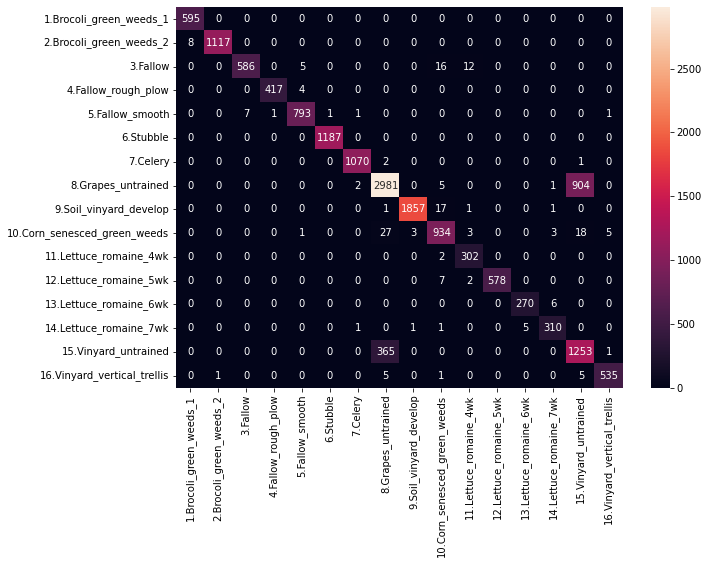

In [46]:

plt.figure(figsize = (10,7))

classes = ['1.Brocoli_green_weeds_1', '2.Brocoli_green_weeds_2',
                      '3.Fallow',
                      '4.Fallow_rough_plow',
                      '5.Fallow_smooth',
                      '6.Stubble',
                      '7.Celery',
                      '8.Grapes_untrained',
                      '9.Soil_vinyard_develop',
                      '10.Corn_senesced_green_weeds',
                      '11.Lettuce_romaine_4wk',
                      '12.Lettuce_romaine_5wk',
                      '13.Lettuce_romaine_6wk',
                      '14.Lettuce_romaine_7wk',
                      '15.Vinyard_untrained',
                      '16.Vinyard_vertical_trellis']

mat = confusion_matrix(np.add(pred, 1), np.add(np.argmax(y_test, 1), 1))

df_cm = pd.DataFrame(mat, index = classes, columns = classes)

sns.heatmap(df_cm, annot=True, fmt='d')

plt.show()
     